In [6]:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

In [2]:
# set hyperparameters
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [36]:
# Gather datasets
# train_loader = torch.utils.data.DataLoader(
#   torchvision.datasets.MNIST('/files/', train=True, download=True,
#                              transform=torchvision.transforms.Compose([
#                                torchvision.transforms.ToTensor(), # convert to tensor
#                                torchvision.transforms.Normalize(  # normalize values
#                                  (0.1307,), (0.3081,))
#                              ])),
#   batch_size=batch_size_train, shuffle=True)

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.ToTensor()),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [25]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [26]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [31]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './results/model.pth')
      torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [28]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [32]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()


Test set: Avg. loss: 2.3036, Accuracy: 989/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312669
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.301922
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.285668
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.218731
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.200523
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.273898
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.155043
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.192728
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.010262
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.985422
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.909151
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.755082
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.684949
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.567306
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.379448
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.271474
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.264703
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.300462
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.323488
Train Epoch: 1 [12160/

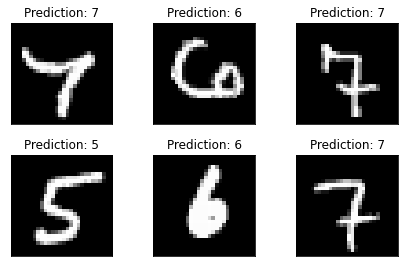

In [35]:
with torch.no_grad():
  output = network(example_data)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])